# CS 166 Final
## Evaluating Bitcoin Trading Strategies by Simulating Time Series Data


## Introduction

In this paper, my goal was to evaluate the effectiveness of several differnet strategies for trading Bitcoin. I wanted to be able to determine which strategy is most effective, or if there are different strategies that are more effective at accomplishing certain goals. My goal was to created simulated future time series data using Monte Carlo methods and then backtest several the various strategies on the data, to find a distribution of results (total value of cash and holdings) for each strategy.



# Past Data

I first had to access and import historical time series data of Bitcoin prices. I used the Bitcoin Price API package for python to do this. I got data from January 1st, 2012 to April 19th, 2018.

In [544]:
## This is a list of packages and setting that were used in the simulation

# This is from the bitcoin-price-api package
from exchanges.coindesk import CoinDesk
import datetime
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from __future__ import division
import time

In [205]:
# Get data from CoinDesk API
btc = CoinDesk.get_historical_data_as_dict(
                    start='2012-01-01', end=None)

I then imported the data into a Pandas Series data structure. A time series graph is shown below.

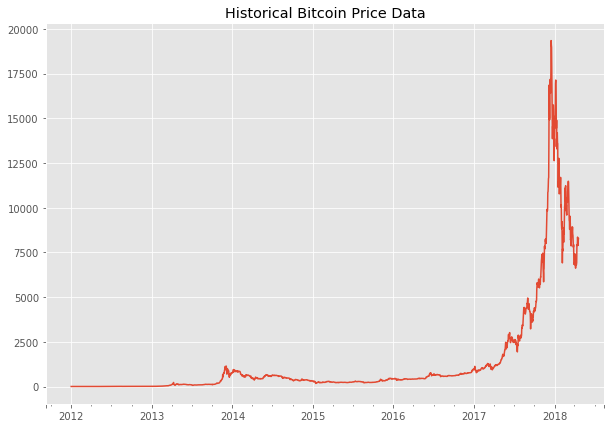

In [470]:
date_list = []
price_list = []
for i in btc:
    date_list.append(i)
    price_list.append(float(btc[i]))
date_list = pd.to_datetime(date_list)
df = pd.Series(price_list, index = date_list)

df.plot(figsize=(10,7),
    title = "Historical Bitcoin Price Data",
    grid = True,
    use_index = True)
plt.show()

With the rapid price increase in 2017 increasing the scale, it is hard to tell any meaningful information about much of the early data. We can plot the same data with a log scale on the Y axis in order to see more information.

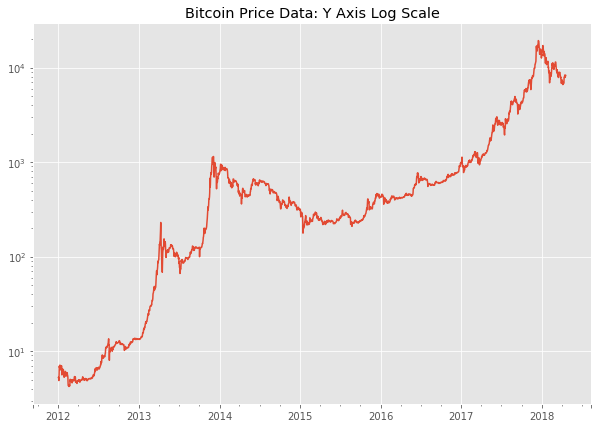

In [207]:
df.plot(figsize=(10,7),
    title = "Bitcoin Price Data: Y Axis Log Scale",
    grid = True,
    # Change logy to True
    logy = True,
    use_index = True)
plt.show()

Taking the log of the Y axis shows us how much the price increases relative to what value it currently has. We can see that althought the recent boom garnered much press attention, the period at the beginning of 2013 saw the explosion of the value of Bitcoin, going from $10 to $100 in a couple of months. From this graph, we can see that the volatility that Bitcoin has becomed recently known for has been present in its time series.

A naive approach would be test our trading schemes against this historical Bitcoin data. However, this is problematic, as it can lead to the problem of overfitting, where the trading scheme that performs best on the historic data is deemed the best. This would not be ideal, as the future data will not simply be a repetition of the past. We need a trading scheme that gives us the best odds of being succesful in the future. What we can do to solve this problem is to randomally sample from the distribution of historical data to create potential future price data.

We will first find the daily percentage change for each day that we have data for. We will then sample from this distribution to create our model. This is similar to a random walk, expect that instead of sampling from the normal distribution we are sampling from the distribution of historical daily percentage changes. 

This is useful as the data we generate will have the same characteristics as the historical data, namely how much the price is likely to change in a day. These models will not neccesarilly be useful for price predictions, as there are many more factors that contribute to the price. However, they will be effective for predicting the success of trading algorithims on data that has similar properties to previous Bitcoin data. A key assumption is that the distribution of daily percentage change will be similar in the future as to what it has been in the past.

## Sampling

The first thing we must do is to find the distribution of daily percentage change in price for the historic data that we have.

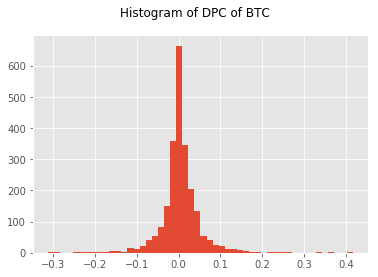

count    2300.000000
mean        0.004308
std         0.047048
min        -0.310939
25%        -0.010886
50%         0.002446
75%         0.020612
max         0.415880
dtype: float64


In [479]:
# Pandas has a built in function for percentage change
daily_pct_change = df.pct_change()
# Plot a hist
plt.figure()
plt.suptitle( "Histogram of DPC of BTC")
daily_pct_change.hist(bins = 50 )
plt.show()
# And show summary stats
print(daily_pct_change.describe())

From the histrogram and summary statistics, we can see that the distribution is not normal. There is a high peak centered at just above zero, with long tail extending on both direction, though extending farther to the right (positive direction) than to the left. 

We would like to sample from something similar to this distribution. We can make another assumption about the future. It is likely that the future daily dercentage change will be more similar to the recent history of Bitcoin than its history from years ago. To account for this, we can create a new data set, which has the values from the two years ago to one year ago included twice and for the most recent year included 3 times. 

In [480]:
samp = np.array(daily_pct_change)
samp = np.array(samp[1:])

samp2 = list(samp[-365:])
samp3 = list(samp[-730:])
samp4 = np.array(list(samp) + samp2 + samp3)

We now need to create a way to sample from this histogram. To do this we can create a cdf from the data, and then input random numbers between 0 and 1 to get a random sample from the original distribution.

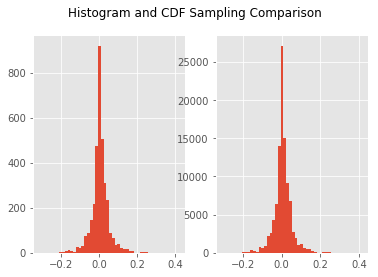

In [486]:
data = samp4
hist, bins = np.histogram(data, bins=50)

bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]
# Input 10,000 random values into the cdf
values = np.random.rand(100000)
value_bins = np.searchsorted(cdf, values)
random_from_cdf = bin_midpoints[value_bins]

plt.suptitle("Histogram and CDF Sampling Comparison")
plt.subplot(121)
plt.hist(data, 50)
plt.subplot(122)
plt.hist(random_from_cdf, 50)
plt.show()

We can see that the distributions are the same. Thus, when we use our sampling technique, we will get accurate samples from the historical Bitcoin data.

## Generate a Time Series

We now can use our sampling technique to create possible time series for the future. We want to create data for one year in the future. We can create a function that does just this, by sampling random values from the distribution, adding 1, and multiplying the value we get by the most recent price. We can do this 20 times and plot the results to see what our simulations look like. 

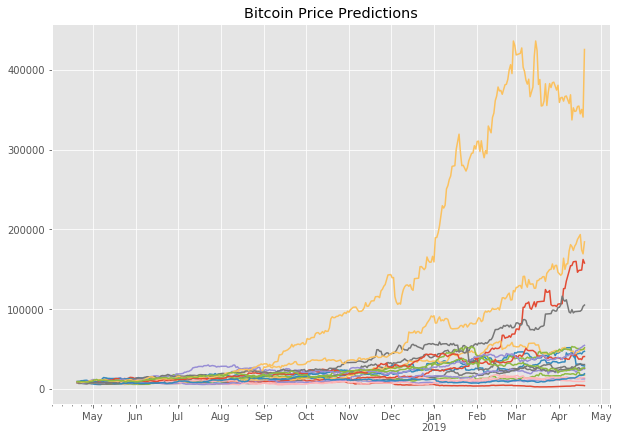

In [411]:
numdays= 365
base = datetime.datetime.today().date()
future_date_list = [base + datetime.timedelta(days=x) for x in range(0, numdays)]
future_date_list = pd.to_datetime(future_date_list)

def price_sample(dates,cdf):
    values = np.random.rand(365)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
    future_prices = [df[-1]]
    for num in random_from_cdf:
        future_prices.append(future_prices[-1]*(num+1))
    future_prices = np.array(future_prices[1:])
    pred = pd.Series(future_prices, index = future_date_list)
    return pred

for i in range(20):
    pred = price_sample(future_date_list, cdf)   
    pred.plot(figsize=(10,7),
        title = "Bitcoin Price Predictions",
        grid = True,
        use_index = True,
        logy = False)
plt.show()

Again, it is quite difficult to see what is happening with most of the simulations as the scale became incredibly large because of a few instances. Again, we can take the log of the y axis to see more.

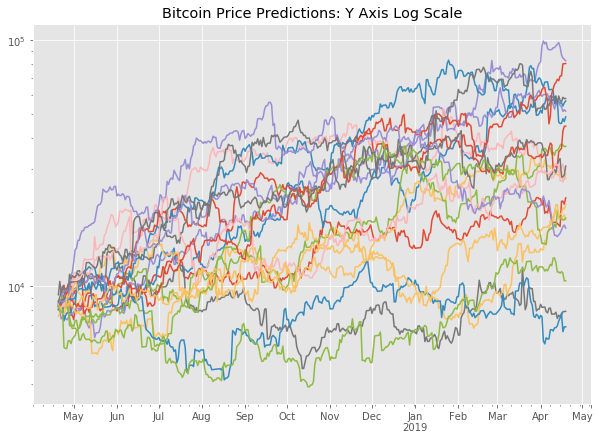

In [487]:
for i in range(20):
    pred = price_sample(future_date_list, cdf)   
    pred.plot(figsize=(10,7),
        title = "Bitcoin Price Predictions: Y Axis Log Scale",
        grid = True,
        use_index = True,
        logy = True)
plt.show()

These 20 simulations show possible future time series data for Bitcoin. Analyzing this graph, we can see that the behaviour is similar to how Bitcoin has performed previously with respect to the distribution of daily percentage change.

While if we created a histogram of each individual time series we may not get a similar histogram to our original data, we know that we are going to create a huge number of these time series and have already shown what histogram sampling 10,000 daily price changes creates. We will create a list, `sim_10k`, that has 10,000 time series's sampled from our ditribution.

In [457]:
sim_10k = []
for _ in range(10000):
    sim_10k.append(price_sample(future_date_list, cdf))
  

# Trading

The next step is to devise and test our trading strategies. We will create one instance of our simulation to visualize how our trading strategies work. 

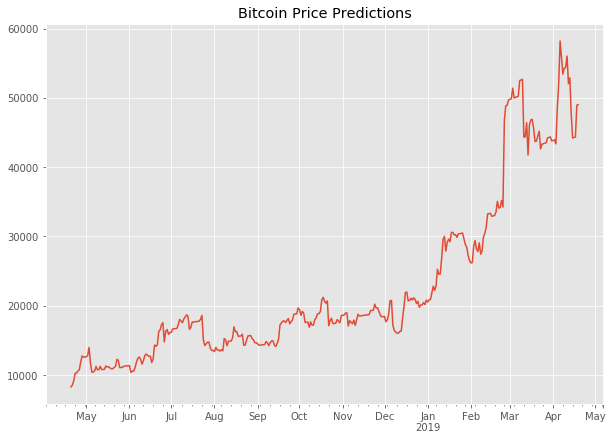

In [493]:
# Create a test time series
test = price_sample(future_date_list, cdf)
test.plot(figsize=(10,7),
    title = "Bitcoin Price Predictions",
    grid = True,
    use_index = True,
    logy = False, y = "Price in USD")
plt.show()

## Simple Moving Average

In this simulation, I will be testing the moving average crossover trading strategy with different parameters. The simple moving average strategy works by creating two Simple Moving Averages (SMA) of a time series with different lookback scales. The SMA takes the mean of the data over the past X days. We will have one short moving average and one long moving average (for our example we choose 20 days and 40 days). If the short moving average becomes higher than the long moving average, we predict that the price is rising and buy, and if the long moving average becomes highers than the short moving average, we predict the opposite. When we think the price will go up, we buy a certain percentage of our wealth (in our example we use 50%) in Bitcoin, and when we think it will go down we sell all of our assets. Thus, we buy low and sell high. 

In [494]:
# Initialize the short and long windows
short_window = 20
long_window = 40

def trading_alg(short_window, long_window, data):

    signals = pd.DataFrame(index = data.index)
    signals['signal'] = 0.0

    # Create short simple moving average over the short window
    signals['short_mavg'] = data.rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average over the long window
    signals['long_mavg'] = data.rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals (which is higher)
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   
    # Generate trading orders (only trade when it switches)
    signals['positions'] = signals['signal'].diff()

    return signals

signals = trading_alg(short_window, long_window, test)

We run this algorithm on our test data set, and we can visualize what happens in the following plot.

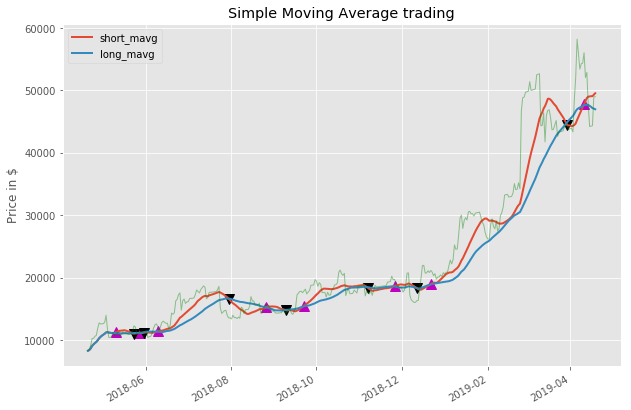

In [496]:
def trading_plot(signals, data):
    # Initialize the plot figure
    fig = plt.figure(figsize=(10,7))

    ax1 = fig.add_subplot(111, title = "Simple Moving Average trading", ylabel='Price in $')

    # Plot the buy signals
    ax1.plot(signals.loc[signals.positions == 1.0].index, 
             signals.short_mavg[signals.positions == 1.0],
             '^', markersize=10, color='m')

    # Plot the sell signals
    ax1.plot(signals.loc[signals.positions == -1.0].index, 
             signals.short_mavg[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the short and long moving averages
    signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

    # Plot the closing price
    data.plot(ax=ax1, color='g', lw=1., alpha = 0.4)
    

    plt.show()
    
trading_plot(signals, test)

We can see the plot of short and long moving averages along with the daily price. The purple triangles indicate where we bought Bitcoin and the black triangles show where we sold. This is an illustrative figure of the process, but it doesn't show us how much money we made and thus how succesful the strategy was.

We can define the following function which buys and sells the correct amount of Bitcoin based on the signals we are given from our trading algorithm. We start with $100,000 USD and will see how much we end up with.

In [424]:
def backtest(initial_capital, signals, data, percent):
    """Holdings = 1, cash = 2"""
    holdings = [0]
    cash = [initial_capital]
    value = [initial_capital]
    for i in range(len(data)):
        # no action
        if signals.positions[i]==0:
            holdings.append(holdings[-1])
            cash.append(cash[-1])
            value.append(cash[-1]+holdings[-1]*data[i])
        # Buy
        elif signals.positions[i]==1:
            bought = cash[-1]*percent
            btc = bought/data[i]
            holdings.append(holdings[-1]+btc)
            cash.append(cash[-1]-bought)
            value.append(cash[-1]+holdings[-1]*data[i])
        # Sell
        elif signals.positions[i]==-1:
            sold = holdings[-1]*data[i]
            holdings.append(0)
            cash.append(cash[-1]+sold)
            value.append(cash[-1]+holdings[-1]*data[i])
    
    portfolio = pd.DataFrame(index=signals.index).fillna(0.0)
    portfolio['holdings']= holdings
    portfolio['cash']=cash
    portfolio['total']=value
    
    return portfolio


portfolio = backtest(100000,signals, test, .5)

We can plot the results, along with the times when we traded.

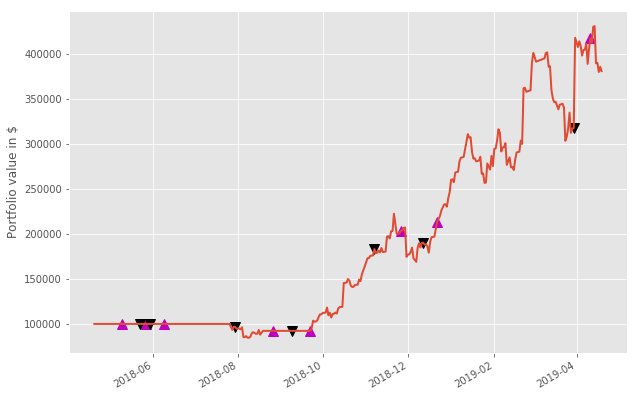

In [500]:
def value_plot(portfolio,signals):

    # Create a figure
    fig = plt.figure(figsize =(10,7) )
    ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')


    ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
             portfolio.total[signals.positions == 1.0],
             '^', markersize=10, color='m')

    ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
             portfolio.total[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the equity curve in dollars
    portfolio['total'].plot(ax=ax1, lw=2.)

    # Show the plot
    plt.show()
    
value_plot(portfolio,signals)

From the figure, we can see that our trading algorithm seemed to be fairly succesful. We made a large profit in only a year! When should you invest you may ask?? However, we must remember that this is not the real future of Bitcoin prices. To determine which is the best strategy, we must run our strategies over all 10,000 of our simulations.

## Simulation

We create strategies of with various lookback times for our small and large lookback, and varying proportions of our wealth that we invest each time.

In [469]:
start_time = time.time()
param_list = [(30,70,.2),(30,70,.5),(30,70,.8),
              (70,120,.2),(70,120,.5),(70,120,.8),
              (30,120,.2),(30,120,.5),(30,120,.8)]

final_results = []

for param in param_list:
    start_time_1 = time.time()
    test_result_mat = []
    signal_port_list = []
    short_window = param[0]
    long_window = param[1]
    p = param[2]
    for data in sim_10k:
        signals = trading_alg(short_window, long_window, data)
        portfolio = backtest(100000,signals, data, p)
        test_result_mat.append(portfolio['total'][-1])
        signal_port_list.append([signals,portfolio])
    print (time.time()-start_time_1)
    final_results.append([test_result_mat,signal_port_list])
print (time.time()-start_time)

    

194.2674057483673
200.92849922180176
199.14726209640503
191.18809604644775
172.21946024894714
185.68920421600342
190.06981897354126
178.67446398735046
203.50647020339966
1715.6922061443329


We have succesfully done our simulation, which took about 30 minutes to run on a 13' MacBook Pro. We can now plot historgrams of the resulting distributions of final value.

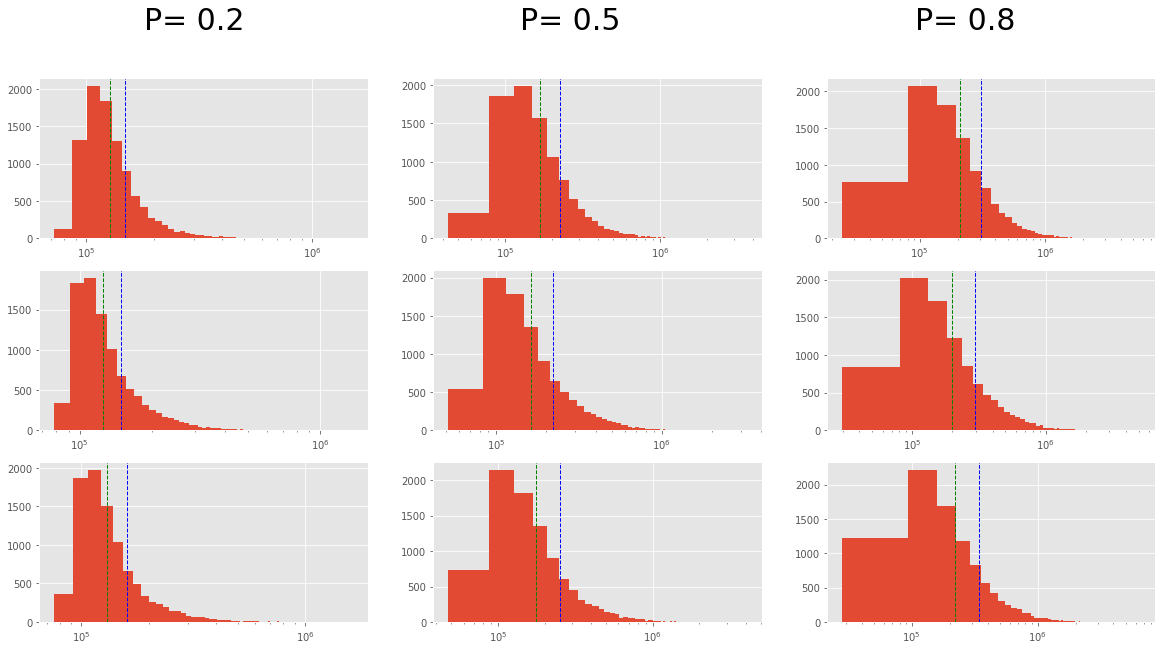

In [538]:

plt.figure(figsize = (20,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.hist(final_results[i-1][0], bins = 100, label = "x")
    plt.xscale('log')
    plt.axvline(np.mean(final_results[i-1][0]), color = "blue", linestyle='dashed', linewidth=1)
    plt.axvline(np.median(final_results[i-1][0]), color = "green", linestyle='dashed', linewidth=1)
    plt.suptitle("P= 0.2                             P= 0.5                               P= 0.8", fontsize = 30 )
plt.show()

In [542]:
for i in range(9):
    data = final_results[i][0]
    print ("The paramaters for this simulation are: ", param_list[i])
    print ("The mean is: ", np.mean(data))
    print ("The median is: ", np.median(data))
    print ("The 10th and 90th percentiles are :", np.percentile( data, 10), "and", np.percentile( data, 90))
    print ("\n ______________\n")

The paramaters for this simulation are:  (30, 70, 0.2)
The mean is:  148829.003704321
The median is:  127143.85245019721
The 10th and 90th percentiles are : 97968.02724608255 and 215806.31506287312

 ______________

The paramaters for this simulation are:  (30, 70, 0.5)
The mean is:  226712.64555309268
The median is:  168146.77872994036
The 10th and 90th percentiles are : 93783.55441575918 and 405973.2833034298

 ______________

The paramaters for this simulation are:  (30, 70, 0.8)
The mean is:  310124.1411284831
The median is:  208975.7998566996
The 10th and 90th percentiles are : 88221.72295950878 and 621448.3014397172

 ______________

The paramaters for this simulation are:  (70, 120, 0.2)
The mean is:  148711.60014615193
The median is:  125135.8281435626
The 10th and 90th percentiles are : 96677.71633481779 and 228296.08011531967

 ______________

The paramaters for this simulation are:  (70, 120, 0.5)
The mean is:  222349.74527879906
The median is:  162751.67749678227
The 10th a

From this, we can make final analysis about which strategy we should use. We see that increasing p leads to significantly higher mean values, while yeilding only slightly smaller 10th percentile values. By increasing p from 0.2 to 0.8, we only decrease the 10th percentile by around 10,000 dollars each time, while doubling the mean value. This makes sense, as the general trend for Bitcoin over the past years has been incredibly positive, and thus investing more money should yeild higher returns. The small decrease in 10th pecentile comes from more risk, but we can see that the reward greatly outwieghs the risk. 

When it comes to simple moving average trading strategies, we see that the largest gap between the short and long (30 to 120) yeilds the highest results. Thus, if we were going to be doing simple mean trading, we should implement it with a larger difference between the two values. This kind of strategy trades less, as it takes more for the algorithm to buy or to sell. From this, it seems that ~~hodl~~ holding Bitcoin for longer periods seems to yield higher results.

Overall, from our simulation we have found that betting higher proportions of wealth pays off while trading with Bitcoin. Secondly, we can see that using a simple moving average trading strategy with a larger gap and less trades is a dominate strategy. This paper can serve as a nice stepping stone for further analysis of Bitcoin markets. These techniques have been studying and utilized on traditional markets for years, but the Bitcoin market and Crypto markets as a whole are immature, and there is much more room for application and discovery.